In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [2]:
config = [{"nj":"NewJersey"},{"ny":"NewYork"},{"pa":"Pennsylvania"},{"ma":"Massachusetts"},{"ct":"Connecticut"}]
folder, state = '',''
for key, value in config[0].items():
    folder = key
    state = value

#realtor_data_df = pd.read_csv(folder + '/' + state + '-realtor-data.csv')

realtor_data_df = pd.read_csv(folder + '/prev_date_sold.csv')

realtor_data_df.dropna(inplace=True)

In [3]:
realtor_data_df['date_sold']=pd.to_datetime(realtor_data_df['prev_sold_date'])

In [4]:
realtor_data_df['date_sold'].max()

Timestamp('2023-03-01 00:00:00')

In [5]:
sold_series = realtor_data_df.groupby(["date_sold"])["price"].sum()
sold_series.head()

date_sold
1978-01-10    410000.0
1978-03-15    129000.0
1978-03-16    694900.0
1978-03-20     75000.0
1978-06-08    210000.0
Name: price, dtype: float64

In [6]:
#date_df = sold_series_df.set_index(pd.date_range('1953-01-02', '2023-03-01', freq='D')).drop('date_sold', axis=1)
date_series = pd.Series(0, index=pd.date_range(realtor_data_df['date_sold'].min(), realtor_data_df['date_sold'].max(), freq='D'))
date_series.head()

1978-01-10    0
1978-01-11    0
1978-01-12    0
1978-01-13    0
1978-01-14    0
Freq: D, dtype: int64

In [7]:
for index,value in sold_series.items():
   date_series[index] = value

date_series.tail()

2023-02-25          0
2023-02-26          0
2023-02-27          0
2023-02-28          0
2023-03-01    1578420
Freq: D, dtype: int64

In [8]:
#date_df = pd.DataFrame(date_series[date_series != 0])
date_df = pd.DataFrame(date_series)
date_df.rename(columns={0:"price"},inplace=True)
date_df.sort_values(by="price")

,price
2000-08-05,0
1995-09-23,0
1995-09-24,0
1995-09-25,0
2016-01-01,0
...,...
2022-04-15,14435290
2022-04-08,16396694
2022-05-06,16416599
2022-03-31,18461300


In [9]:
#date_df = date_df[(date_df != 0).all(1)]
#date_df

In [10]:
y_hist=date_df.loc['1992-01-01':'2012-12-31']
y_future=date_df.loc['2013-01-01':'2023-03-01']

print('Historical:')
print(y_hist.head())
print('=========\nFuture:')
print(y_future.tail())

Historical:
             price
1992-01-01       0
1992-01-02       0
1992-01-03  959900
1992-01-04       0
1992-01-05       0
Future:
              price
2023-02-25        0
2023-02-26        0
2023-02-27        0
2023-02-28        0
2023-03-01  1578420


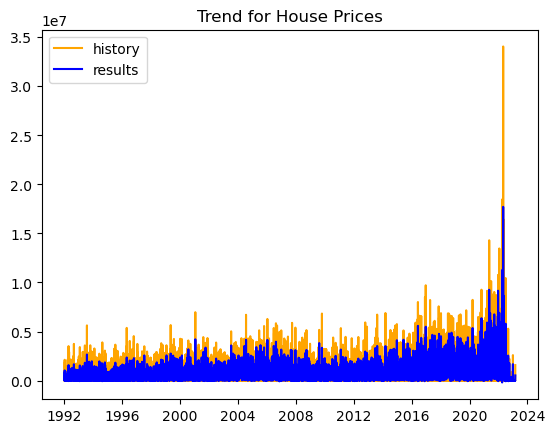

In [11]:
stl=STL(date_df.loc['1992-01-01':], period=2)
results=stl.fit()
#pd.plotting.register_matplotlib_converters()

plt.plot(date_df.loc['1992-01-01':], label="history", color="orange")
plt.plot(results.trend, label="results", color="blue")
plt.title('Trend for House Prices')
plt.legend()

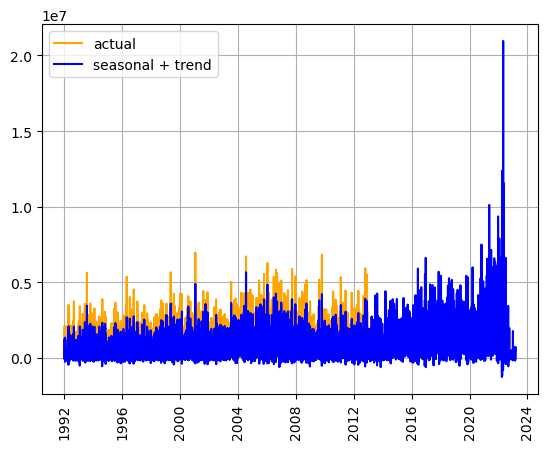

In [12]:
season_and_trend=results.seasonal + results.trend

plt.plot(y_hist, label='actual', color="orange")
plt.plot(season_and_trend, label='seasonal + trend', color="blue")
plt.grid()
plt.legend()
plt.xticks(rotation=90);

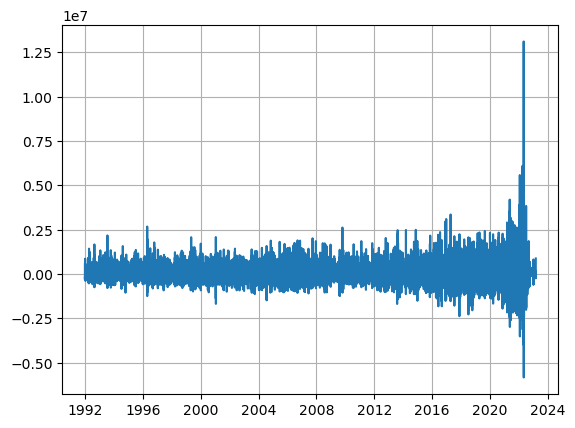

In [13]:
plt.plot(results.resid)
plt.grid()

In [14]:
#, model_kwargs={'order':(1, 1, 0), 'trend':"t"}
stlf=STLForecast(y_hist, ARIMA, model_kwargs={"order": (0, 1, 1)})
#fit model using historical data
stlf_results=stlf.fit()

In [15]:
#stlf_results.get_prediction(start=y_hist.index[0], end=y_hist.index[0], dynamic=False)
#stlf_results.get_prediction(start=len(y_hist), dynamic=True)

In [16]:
#produce forecast for future data
forecast=stlf_results.forecast(len(y_future))
'''
forecast=stlf_results.forecast(steps=len(y_future))

forecast_df = pd.DataFrame(forecast)
forecast_df.rename(columns={0:"price"},inplace=True)
forecast_df
'''

'\nforecast=stlf_results.forecast(steps=len(y_future))\n\nforecast_df = pd.DataFrame(forecast)\nforecast_df.rename(columns={0:"price"},inplace=True)\nforecast_df\n'

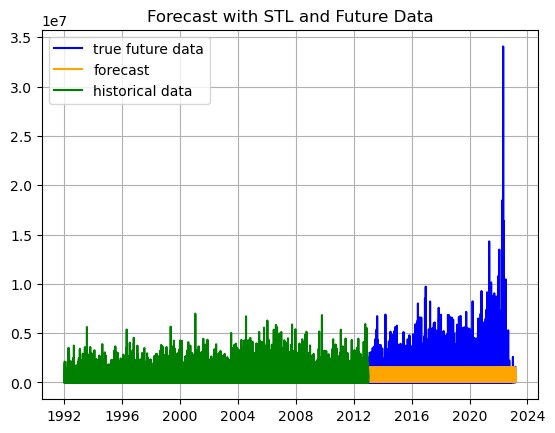

In [17]:
plt.plot(y_future, label='true future data',color="blue")
plt.plot(forecast, label='forecast',color="orange")
plt.plot(y_hist, label='historical data',color="green")
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid()

In [18]:
pred_error=y_future.price - forecast

mse=np.mean(pred_error)
mae=np.abs(pred_error).mean()
rmse=np.sqrt((pred_error**2).mean())

print("MSE: {:,.9f}".format(mse))
print("MAE: {:,.9f}".format(mae))
print("RMSE: {:,.9f}".format(rmse))

MSE: 841,693.009428336
MAE: 1,285,763.304464634
RMSE: 2,062,510.774257185
